# Validating $Monod$ burst size inference using seqFISH+ data


Data: seqFISH+ count matrices for introns (adjusted by intensity) and mRNA (not adjusted by intensity).


** There should only be 1-2 intron spots per cell (which is indeed the case).

These count matrices are used to fit *Monod* and the inferred burst sizes are compared to seqFISH+ burst sizes (calculated by averaging the intensity values over intron spots in a given cell). 





In [2]:
# import packages
import os,sys
sys.path.insert(0, '../monod/src/')

import numpy as np
import pandas as pd
import pickle
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix

# colors
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rc('xtick', labelsize=24) 
matplotlib.rc('ytick', labelsize=24) 

# single cell
import anndata
import scanpy as sc

# import Monod
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis


In [175]:
def nd(matrix):
    
    return(np.array(nd).flatten())

# Load in seqFISH+ counts

In [21]:
# seqFISH_result_path = '/home/tara/temp_git2/CGCCP_2023/Manuscript/results'
# with open(f'{seqFISH_result_path}/E14_rep1_seqFISH_biVI_parameters_adj_introns_subset','rb') as file:
#     seqFISH_rep1_parameters = pickle.load(file)
# with open(f'{seqFISH_result_path}/E14_rep2_seqFISH_biVI_parameters_adj_introns_subset','rb') as file:
#     seqFISH_rep2_parameters = pickle.load(file)
    

In [46]:
# seqFISH_rep1_parameters.keys()

dict_keys(['mean', 'dispersions', 'unspliced_means', 'spliced_means', 'burst_size', 'rel_splicing_rate', 'rel_degradation_rate', 'seqFISH_burst_size', 'gene_name', 'cell_id', 'intron_counts', 'exon_counts'])

In [74]:
# # create anndata object for rep1 and rep2 mESCs (Takei data) 

# # create anndata, first with rep1
# adata_1 = anndata.AnnData(csr_matrix(seqFISH_rep1_parameters['intron_counts'], dtype=np.float32))
# adata_1.layers['unspliced'] = csr_matrix(seqFISH_rep1_parameters['intron_counts'], dtype=np.float32)
# adata_1.layers['spliced'] = csr_matrix(seqFISH_rep1_parameters['exon_counts'], dtype=np.float32)

# adata_1.var['gene_name'] = seqFISH_rep1_parameters['gene_name']
# adata_1.obs['cell'] = np.arange(len(adata_1)).tolist()


# # create anndata, now with rep2
# adata_2 = anndata.AnnData(csr_matrix(seqFISH_rep2_parameters['intron_counts'], dtype=np.float32))
# adata_2.layers['unspliced'] = csr_matrix(seqFISH_rep2_parameters['intron_counts'], dtype=np.float32)
# adata_2.layers['spliced'] = csr_matrix(seqFISH_rep2_parameters['exon_counts'], dtype=np.float32)

# adata_2.var['gene_name'] = seqFISH_rep2_parameters['gene_name']
# adata_2.obs['cell'] = np.arange(len(adata_2)).tolist()


In [76]:
# # and save as loom files for Monod fits
# adata_1.write_loom('data/es_rep1.loom')
# adata_2.write_loom('data/es_rep2.loom')



# Fit $Monod$


First on Rep1, then on Rep2.




In [87]:
!mkdir -p monod_fits/

In [160]:
dataset_names = ['es_rep2.loom']  

transcriptome_filepath = './transcriptome/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'cell'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['./data/'+ x for x in dataset_names] 
n_datasets = len(loom_filepaths)

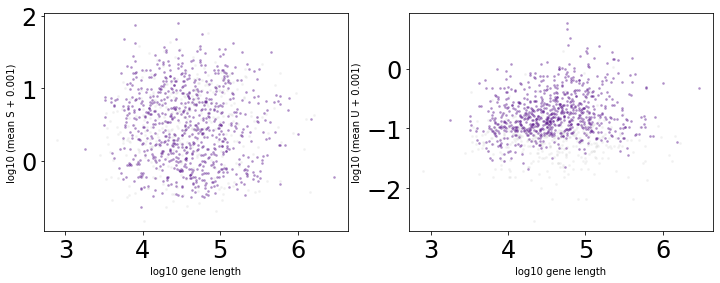

In [162]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./monod_fits',batch_id=1,\
                                             n_genes=2000)

## Bursty model with no technical noise

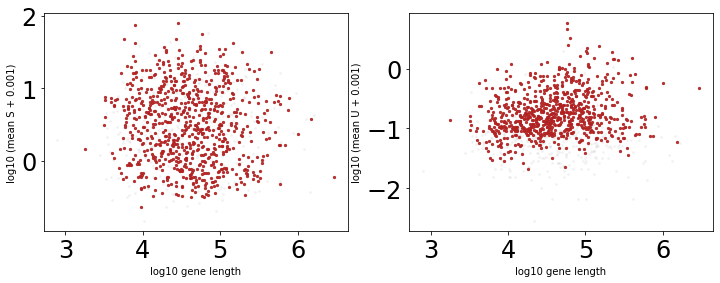

In [499]:
lb = [-1.0, -1.8, -1.8 ]
ub = [4.2, 2.5, 3.5]
samp_lb = [1,1]
samp_ub = [1,1]
gridsize = [1,1]

result_strings_2 = []

for i in range(n_datasets):
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','None',quad_method='fixed_quad')
    inference_parameters = monod.inference.InferenceParameters(lb,ub,samp_lb,samp_lb,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = False,
                gradient_params = {'max_iterations':0,'init_pattern':'moments','num_restarts':1})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                        dataset_strings[i], dir_string, dataset_attr_names=attribute_names)
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
    result_strings_2.append(full_result_string)

In [500]:
# save parameters
dir_string = './monod_fits/gg_231018_026_batch_1'
dataset_strings = [dir_string+'/'+ x for x in dataset_names]
result_strings_2 = [x+'/Bursty_None_1x1/grid_scan_results.res' for x in dataset_strings]


for i,f in enumerate(result_strings_2):
    print(f)
    name = dataset_names[i][:-5]
    res = monod.analysis.load_search_results(f)
    # index of optimum! 
    opt_samp = res.find_sampling_optimum()
    opt_ind = res.samp_optimum_ind
    opt_params = res.param_estimates[opt_ind,:,:]
    opt_df = pd.DataFrame(opt_params)
    opt_df['gene_name'] = search_data.gene_names
    opt_df.to_csv(f'./MONOD_opt_params_{name}_bursty_none.csv')

./monod_fits/gg_231018_026_batch_1/es_rep2.loom/Bursty_None_1x1/grid_scan_results.res


# Plot

In [501]:
seqFISH_rep1_parameters.keys()

dict_keys(['mean', 'dispersions', 'unspliced_means', 'spliced_means', 'burst_size', 'rel_splicing_rate', 'rel_degradation_rate', 'seqFISH_burst_size', 'gene_name', 'cell_id', 'intron_counts', 'exon_counts'])

In [502]:
# load in seqFISH+ counts used in biVI validation
seqFISH_result_path = './results'
    

with open(f'{seqFISH_result_path}/E14_rep2_seqFISH_biVI_parameters_adj_introns_monod_genes','rb') as file:
    seqFISH_rep2_parameters = pickle.load(file)
    

es_rep2_df_subset = pd.DataFrame({
    'gene_name' : seqFISH_rep2_parameters['gene_name'],
    'burst_size' : seqFISH_rep2_parameters['seqFISH_burst_size'].mean(axis=0),
    'burst_size_variance' : seqFISH_rep2_parameters['seqFISH_burst_size'].var(axis=0),
    'mean_intron_counts' : seqFISH_rep2_parameters['intron_counts'].mean(axis=0),
    'mean_adj_intron_counts' : seqFISH_rep2_parameters['intron_counts'].mean(axis=0),
    'mean_exon_counts' : seqFISH_rep2_parameters['exon_counts'].mean(axis=0)
})


biVI_rep2_df = pd.DataFrame({
    'gene_name' : seqFISH_rep2_parameters['gene_name'],
    'burst_size' : seqFISH_rep2_parameters['burst_size'].mean(axis=0),
    'burst_size_variance' : seqFISH_rep2_parameters['burst_size'].var(axis=0),
    'unspliced_means' : seqFISH_rep2_parameters['unspliced_means'].mean(axis=0),
    'spliced_means' : seqFISH_rep2_parameters['spliced_means'].mean(axis=0),
    'rel_degradation_rate' : seqFISH_rep2_parameters['rel_degradation_rate'].mean(axis=0),
    'rel_splicing_rate' : seqFISH_rep2_parameters['rel_splicing_rate'].mean(axis=0),
})



In [503]:
# extract data
beta_bursty_no_noise = 10**opt_df[1].values
gamma_bursty_no_noise = 10**opt_df[2].values
b_bursty_no_noise = 10**opt_df[0].values
mean_u_monod = b_bursty_no_noise/beta_bursty_no_noise
mean_s_monod = b_bursty_no_noise/gamma_bursty_no_noise

b_biVI = biVI_rep2_df[biVI_rep2_df['gene_name'].isin(list(search_data.gene_names))]['burst_size'].values
beta_biVI = biVI_rep2_df[biVI_rep2_df['gene_name'].isin(list(search_data.gene_names))]['rel_splicing_rate'].values
gamma_biVI = biVI_rep2_df[biVI_rep2_df['gene_name'].isin(list(search_data.gene_names))]['rel_degradation_rate'].values
mean_u_biVI = biVI_rep2_df[biVI_rep2_df['gene_name'].isin(list(search_data.gene_names))]['unspliced_means'].values
mean_s_biVI = biVI_rep2_df[biVI_rep2_df['gene_name'].isin(list(search_data.gene_names))]['spliced_means'].values


b_seqFISH = es_rep2_df_subset[es_rep2_df_subset['gene_name'].isin(list(search_data.gene_names))]['burst_size'].values
mean_u_seqFISH = es_rep2_df_subset[es_rep2_df_subset['gene_name'].isin(list(search_data.gene_names))]['mean_intron_counts'].values
mean_s_seqFISH = es_rep2_df_subset[es_rep2_df_subset['gene_name'].isin(list(search_data.gene_names))]['mean_exon_counts'].values



In [504]:
sum(es_rep2_df_subset[es_rep2_df_subset['gene_name'].isin(list(search_data.gene_names))]['gene_name'].values == opt_df['gene_name'].values)

752

In [505]:
sum(biVI_rep2_df[biVI_rep2_df['gene_name'].isin(list(search_data.gene_names))]['gene_name'].values == opt_df['gene_name'].values)


752

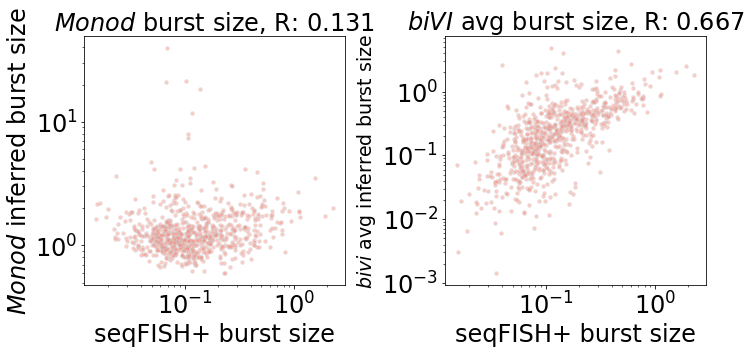

In [506]:
eps = 1e-18
fs=24
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(b_seqFISH,b_bursty_no_noise,s=14,color='salmon',alpha=0.4,edgecolor='lightgray')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('seqFISH+ burst size',fontsize=fs)
ax[0].set_ylabel('$Monod$ inferred burst size',fontsize=fs)
correlation_,p = pearsonr(np.log(b_seqFISH+eps),
                          np.log(b_bursty_no_noise+eps),
                          )
ax[0].set_title(f'$Monod$ burst size, R: {correlation_:.3f}',fontsize=fs)


ax[1].scatter(b_seqFISH,b_biVI,s=14,color='salmon',alpha=0.4,edgecolor='lightgray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('seqFISH+ burst size',fontsize=fs)
ax[1].set_ylabel('$bivi$ avg inferred burst size',fontsize=fs-5)
correlation_,p = pearsonr(np.log(b_seqFISH+eps),
                          np.log(b_biVI+eps),
                          )
ax[1].set_title(f'$biVI$ avg burst size, R: {correlation_:.3f}',fontsize=fs)


plt.tight_layout();


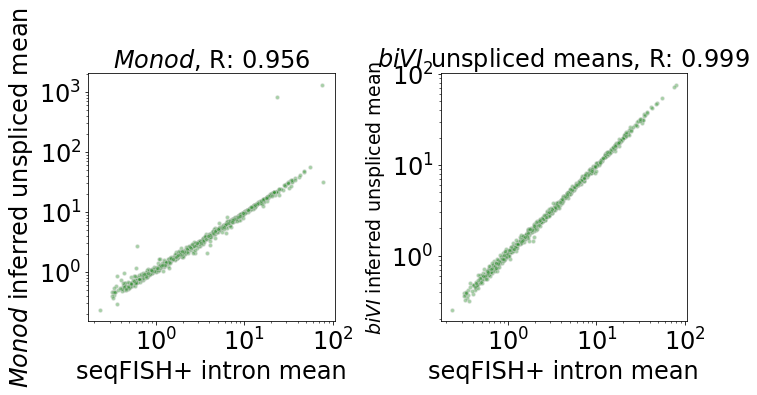

In [507]:
# MEANS -- SPLICED !!! 

eps = 1e-18
fs=24
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(mean_s_seqFISH,mean_s_monod,s=14,color='forestgreen',alpha=0.4,edgecolor='lightgray')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('seqFISH+ intron mean',fontsize=fs)
ax[0].set_ylabel('$Monod$ inferred unspliced mean',fontsize=fs)
correlation_,p = pearsonr(np.log(mean_u_seqFISH+eps),
                          np.log(mean_u_monod+eps),
                          )
ax[0].set_title(f'$Monod$, R: {correlation_:.3f}',fontsize=fs)

ax[1].scatter(mean_s_seqFISH,mean_s_biVI,s=14,color='forestgreen',alpha=0.4,edgecolor='lightgray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('seqFISH+ intron mean',fontsize=fs)
ax[1].set_ylabel('$biVI$ inferred unspliced mean',fontsize=fs-5)
correlation_,p = pearsonr(np.log(mean_s_seqFISH+eps),
                          np.log(mean_s_biVI+eps),
                          )
ax[1].set_title(f'$biVI$ unspliced means, R: {correlation_:.3f}',fontsize=fs)


plt.tight_layout();

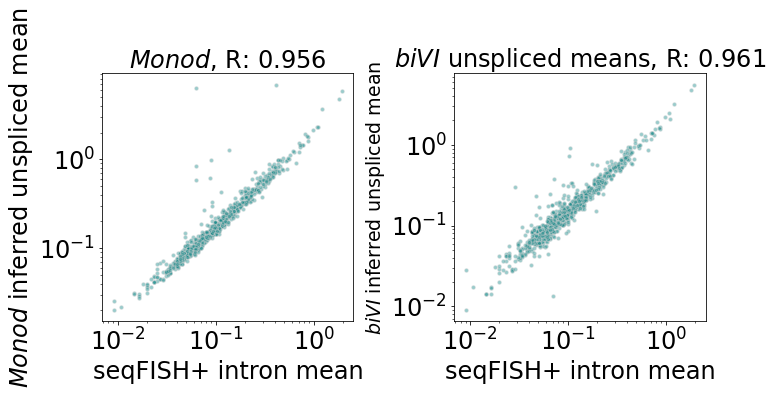

In [508]:
# MEANS !!! 

eps = 1e-18
fs=24
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(mean_u_seqFISH,mean_u_monod,s=14,color='teal',alpha=0.4,edgecolor='lightgray')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('seqFISH+ intron mean',fontsize=fs)
ax[0].set_ylabel('$Monod$ inferred unspliced mean',fontsize=fs)
correlation_,p = pearsonr(np.log(mean_u_seqFISH+eps),
                          np.log(mean_u_monod+eps),
                          )
ax[0].set_title(f'$Monod$, R: {correlation_:.3f}',fontsize=fs)

ax[1].scatter(mean_u_seqFISH,mean_u_biVI,s=14,color='teal',alpha=0.4,edgecolor='lightgray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('seqFISH+ intron mean',fontsize=fs)
ax[1].set_ylabel('$biVI$ inferred unspliced mean',fontsize=fs-5)
correlation_,p = pearsonr(np.log(mean_u_seqFISH+eps),
                          np.log(mean_u_biVI+eps),
                          )
ax[1].set_title(f'$biVI$ unspliced means, R: {correlation_:.3f}',fontsize=fs)


plt.tight_layout();

How much error is there in the computed parameters?

In [ ]:
# res.compute_sigma(search_data)

In [ ]:
# res.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
# plt.title('seqFISH+ mESCs rep2',fontsize=20)
# res.plot_param_marg()

# $Monod$ and $biVI$ parameters with MoM parameters

MoM burst size = var_n/mean_n - 1



In [511]:
b_mom = search_data.layers[0,...].var(axis=1) / search_data.layers[0,...].mean(axis=1) - 1
beta_mom = b_mom / search_data.layers[0,...].mean(axis=1)
gamma_mom = b_mom / search_data.layers[1,...].mean(axis=1) 


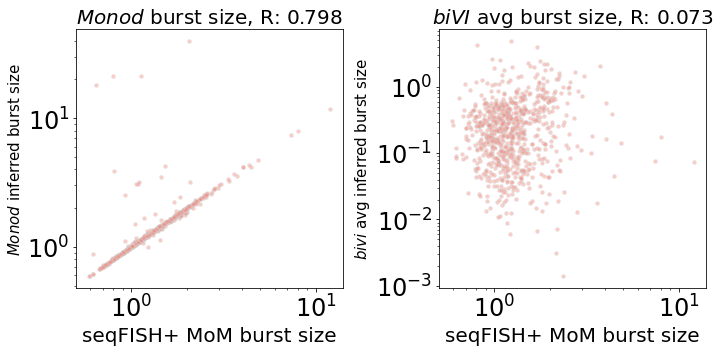

In [514]:
eps = 1e-18
fs=20
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(b_mom,b_bursty_no_noise,s=14,color='salmon',alpha=0.4,edgecolor='lightgray')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('seqFISH+ MoM burst size',fontsize=fs)
ax[0].set_ylabel('$Monod$ inferred burst size',fontsize=fs-5)
correlation_,p = pearsonr(np.log(b_mom+eps),
                          np.log(b_bursty_no_noise+eps),
                          )
ax[0].set_title(f'$Monod$ burst size, R: {correlation_:.3f}',fontsize=fs)


ax[1].scatter(b_mom,b_biVI,s=14,color='salmon',alpha=0.4,edgecolor='lightgray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('seqFISH+ MoM burst size',fontsize=fs)
ax[1].set_ylabel('$bivi$ avg inferred burst size',fontsize=fs-5)
correlation_,p = pearsonr(np.log(b_mom+eps),
                          np.log(b_biVI+eps),
                          )
ax[1].set_title(f'$biVI$ avg burst size, R: {correlation_:.3f}',fontsize=fs)


plt.tight_layout();

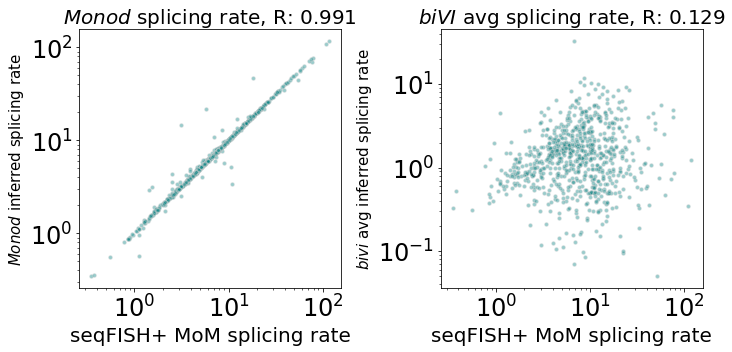

In [517]:
eps = 1e-18
fs=20
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(beta_mom,beta_bursty_no_noise,s=14,color='teal',alpha=0.4,edgecolor='lightgray')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('seqFISH+ MoM splicing rate',fontsize=fs)
ax[0].set_ylabel('$Monod$ inferred splicing rate',fontsize=fs-5)
correlation_,p = pearsonr(np.log(beta_mom+eps),
                          np.log(beta_bursty_no_noise+eps),
                          )
ax[0].set_title(f'$Monod$ splicing rate, R: {correlation_:.3f}',fontsize=fs)


ax[1].scatter(beta_mom,beta_biVI,s=14,color='teal',alpha=0.4,edgecolor='lightgray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('seqFISH+ MoM splicing rate',fontsize=fs)
ax[1].set_ylabel('$bivi$ avg inferred splicing rate',fontsize=fs-5)
correlation_,p = pearsonr(np.log(beta_mom+eps),
                          np.log(beta_biVI+eps),
                          )
ax[1].set_title(f'$biVI$ avg splicing rate, R: {correlation_:.3f}',fontsize=fs)


plt.tight_layout();





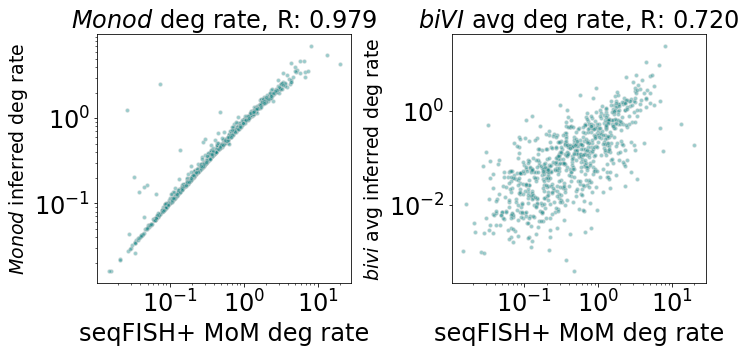

In [516]:
eps = 1e-18
fs=24
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(gamma_mom,gamma_bursty_no_noise,s=14,color='teal',alpha=0.4,edgecolor='lightgray')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('seqFISH+ MoM deg rate',fontsize=fs)
ax[0].set_ylabel('$Monod$ inferred deg rate',fontsize=fs-5)
correlation_,p = pearsonr(np.log(gamma_mom+eps),
                          np.log(gamma_bursty_no_noise+eps),
                          )
ax[0].set_title(f'$Monod$ deg rate, R: {correlation_:.3f}',fontsize=fs)


ax[1].scatter(gamma_mom,gamma_biVI,s=14,color='teal',alpha=0.4,edgecolor='lightgray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('seqFISH+ MoM deg rate',fontsize=fs)
ax[1].set_ylabel('$bivi$ avg inferred deg rate',fontsize=fs-5)
correlation_,p = pearsonr(np.log(gamma_mom+eps),
                          np.log(gamma_biVI+eps),
                          )
ax[1].set_title(f'$biVI$ avg deg rate, R: {correlation_:.3f}',fontsize=fs)


plt.tight_layout();

## Where do the $Monod$ parameters fall within the $biVI$ parameters?

In [359]:
cmap = matplotlib.cm.get_cmap('Spectral')
colors = [cmap(i) for i in range(cmap.N)]

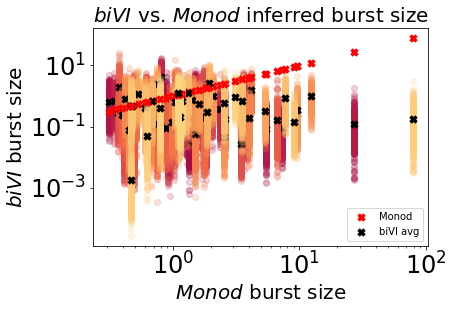

In [360]:
num_genes = 100


for g in range(num_genes):
    b_biVI_ = seqFISH_rep2_parameters['burst_size'][:,g]
    b_monod_ = b_bursty_no_noise[g] * np.ones(len(b_biVI_))
    plt.scatter(b_monod_,b_biVI_,color=colors[g],alpha=0.2)
    plt.scatter(b_monod_[0],b_monod_[0],color='red',marker='X',s=50, label= 'Monod')
    plt.scatter(b_monod_[0],b_biVI_.mean(),color='black',marker='X',s=50,label='biVI avg')
    
    if g == 0:
        plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.ylabel('$biVI$ burst size',fontsize=20)
plt.xlabel('$Monod$ burst size',fontsize=20)
plt.title('$biVI$ vs. $Monod$ inferred burst size',fontsize=20);

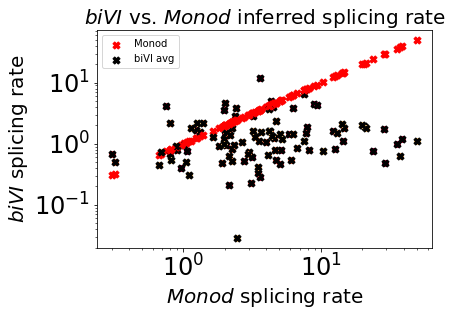

In [361]:
for g in range(num_genes):
    biVI_ = seqFISH_rep2_parameters['rel_splicing_rate'][:,g]
    monod_ = beta_bursty_no_noise[g] * np.ones(len(biVI_))
    plt.scatter(monod_,biVI_,color=colors[g],alpha=0.2)
    plt.scatter(monod_[0],monod_[0],color='red',marker='X',s=50, label= 'Monod')
    plt.scatter(monod_[0],biVI_.mean(),color='black',marker='X',s=50,label='biVI avg')
    
    if g == 0:
        plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.ylabel('$biVI$ splicing rate',fontsize=20)
plt.xlabel('$Monod$ splicing rate',fontsize=20)
plt.title('$biVI$ vs. $Monod$ inferred splicing rate',fontsize=20);

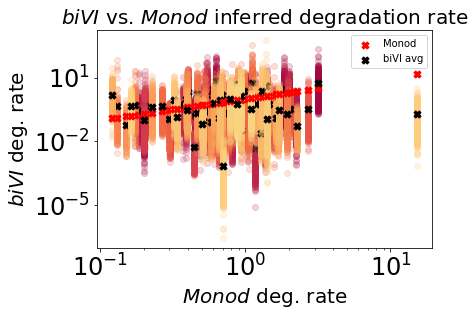

In [362]:
for g in range(num_genes):
    biVI_ = seqFISH_rep2_parameters['rel_degradation_rate'][:,g]
    monod_ = gamma_bursty_no_noise[g] * np.ones(len(biVI_))
    plt.scatter(monod_,biVI_,color=colors[g],alpha=0.2)
    plt.scatter(monod_[0],monod_[0],color='red',marker='X',s=50, label= 'Monod')
    plt.scatter(monod_[0],biVI_.mean(),color='black',marker='X',s=50,label='biVI avg')
    
    if g == 0:
        plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.ylabel('$biVI$ deg. rate',fontsize=20)
plt.xlabel('$Monod$ deg. rate',fontsize=20)
plt.title('$biVI$ vs. $Monod$ inferred degradation rate',fontsize=20);

Burst size dependence on gene length for average *biVI* inferred burst sizes.

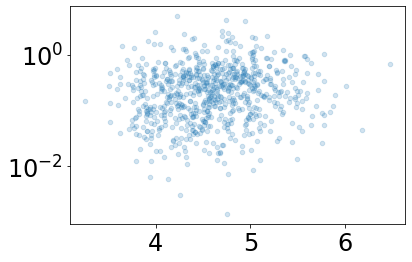

In [365]:

plt.scatter(search_data.gene_log_lengths,b_biVI,s=20,alpha=0.2)
plt.yscale('log')

Text(0.5, 1.0, 'Unspliced means')

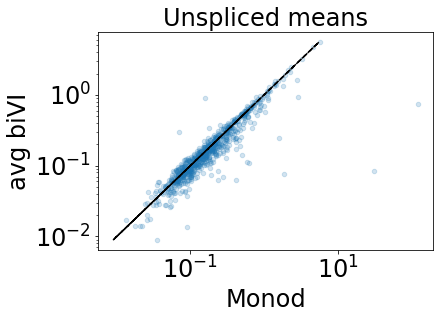

In [369]:
plt.scatter(mean_u_monod,mean_u_biVI,s=20,alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('avg biVI',fontsize=fs)
plt.xlabel('Monod',fontsize=fs)
plt.plot(mean_u_biVI,mean_u_biVI,color='k',linestyle='--')
plt.title('Unspliced means',fontsize=fs)

Text(0.5, 1.0, 'Spliced means')

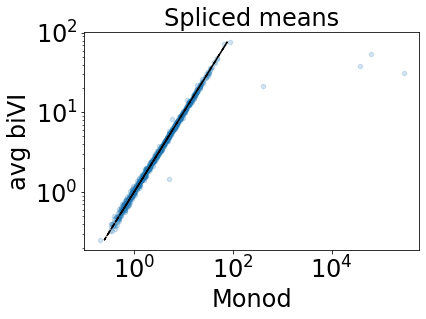

In [368]:
plt.scatter(mean_s_monod,mean_s_biVI,s=20,alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('avg biVI',fontsize=fs)
plt.xlabel('Monod',fontsize=fs)
plt.plot(mean_s_biVI,mean_s_biVI,color='k',linestyle='--')
plt.title('Spliced means',fontsize=fs)

------
# Data likelihood

Data likelihood using *Monod* inferred parameters or using *biVI* inferred parameters and averaging over all cell likelihoods. 





In [529]:
seqFISH_rep2_parameters.keys()

dict_keys(['mean', 'dispersions', 'unspliced_means', 'spliced_means', 'burst_size', 'rel_splicing_rate', 'rel_degradation_rate', 'seqFISH_burst_size', 'gene_name', 'cell_id', 'intron_counts', 'exon_counts'])

In [558]:

index = biVI_rep2_df['gene_name'].isin(list(search_data.gene_names)).values

b_biVI_array = seqFISH_rep2_parameters['burst_size'][:,index]
beta_biVI_array = seqFISH_rep2_parameters['rel_splicing_rate'][:,index]
gamma_biVI_array = seqFISH_rep2_parameters['rel_degradation_rate'][:,index]


In [564]:
N = len(search_data.gene_names)
N=  100
monod_likelihoods = np.ones(N)
biVI_likelihoods_avg = np.ones(N)
biVI_likelihoods_all = np.ones(N)


n_cells = search_data.n_cells

for i in range(N):
    print(i)
    monod_likelihoods[i] = fitmodel.eval_model_logL(p = opt_df.iloc[i].values[:-1], 
                         limits = search_data.M[:,i]+50, 
                         samp=[None,None], 
                         data = search_data.hist[i],
                         n_cells = search_data.n_cells)
    p_biVI = np.log10(np.array([b_biVI[i],
                       beta_biVI[i],
                       gamma_biVI[i]]))
    biVI_likelihoods_avg[i] = fitmodel.eval_model_logL(p = p_biVI, 
                         limits = search_data.M[:,i]+50, 
                         samp=[None,None], 
                         data = search_data.hist[i],
                         n_cells = search_data.n_cells)
    
    biVI_likelihood_ = np.zeros(n_cells)
    for n in np.arange(n_cells):
        p_biVI_all = np.log10(np.array([b_biVI_array[n,i],
                       beta_biVI_array[n,i],
                       gamma_biVI_array[n,i]]))
        biVI_likelihood_[n] = fitmodel.eval_model_logL(p = p_biVI_all, 
                         limits = search_data.M[:,i]+50, 
                         samp=[None,None], 
                         data = search_data.hist[i],
                         n_cells = search_data.n_cells)
    
    # I know this is wrong!!-- i should exponentiate before averaging, but then i get 0 for likelihoods
    biVI_likelihoods_all[i] = np.mean(biVI_likelihood_)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


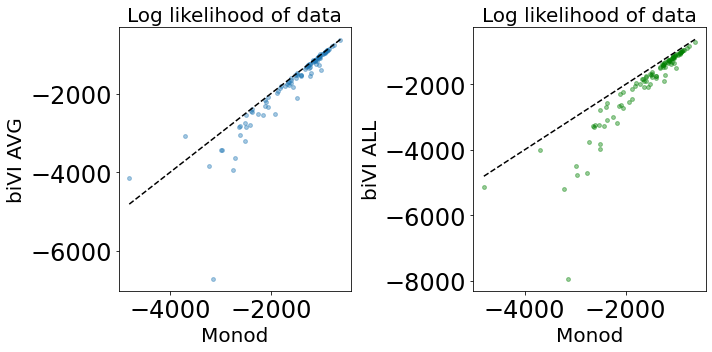

In [568]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(monod_likelihoods,biVI_likelihoods_avg,s=15,alpha=0.4)
ax[0].plot(np.sort(monod_likelihoods),np.sort(monod_likelihoods),linestyle='--',color='k')
ax[0].set_title('Log likelihood of data',fontsize=fs)
ax[0].set_xlabel('Monod',fontsize=fs)
ax[0].set_ylabel('biVI AVG',fontsize=fs)

ax[1].scatter(monod_likelihoods,biVI_likelihoods_all,s=15,alpha=0.4,color='green')
ax[1].plot(np.sort(monod_likelihoods),np.sort(monod_likelihoods),linestyle='--',color='k')
ax[1].set_title('Log likelihood of data',fontsize=fs)
ax[1].set_xlabel('Monod',fontsize=fs)
ax[1].set_ylabel('biVI ALL',fontsize=fs)
plt.tight_layout()

Text(0.5, 0.98, 'Cep68')

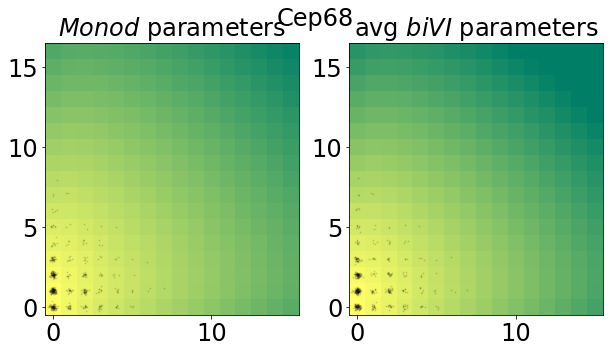

In [463]:
i_ = 260
p_monod = opt_df.iloc[i_].values[:-1]
p_biVI = np.log10(np.array([b_biVI[i_],
                       beta_biVI[i_],
                       gamma_biVI[i_]]))
lm = search_data.M[:,i_]


P_monod = np.squeeze(fitmodel.eval_model_pss(p_monod, lm, samp = [None,None]))
P_biVI = np.squeeze(fitmodel.eval_model_pss(p_biVI, lm, samp = [None,None]))



fig,ax1 = plt.subplots(1,2,figsize=(10,5))

P_monod[P_monod < 1e-10] = 1e-10
P_monod = np.log10(P_monod)
P_biVI[P_biVI < 1e-10] = 1e-10
P_biVI = np.log10(P_biVI)

ax1[0].imshow(P_monod.T, aspect="auto", cmap="summer")
ax1[0].invert_yaxis()

jitter_magn = 0.1
jitter = np.random.randn(2, search_data.n_cells) * jitter_magn
ax1[0].scatter(
                    *search_data.layers[:2, i_] + jitter, c="k", s=1, alpha=0.1
                )

ax1[0].set_xlim([-0.5, search_data.M[0, i_] - 1.5])
ax1[0].set_ylim([-0.5, search_data.M[1, i_] - 1.5])
ax1[0].set_title('$Monod$ parameters',fontsize=24)

ax1[1].imshow(P_biVI.T, aspect="auto", cmap="summer")
ax1[1].invert_yaxis()
jitter_magn = 0.1
jitter = np.random.randn(2, search_data.n_cells) * jitter_magn
ax1[1].scatter(
                    *search_data.layers[:2, i_] + jitter, c="k", s=1, alpha=0.1
                )

ax1[1].set_xlim([-0.5, search_data.M[0, i_] - 1.5])
ax1[1].set_ylim([-0.5, search_data.M[1, i_] - 1.5])
ax1[1].set_title('avg $biVI$ parameters',fontsize=24)

plt.suptitle(search_data.gene_names[i_],fontsize=24)